<HTML>
    <H1>
        <center><Strong>MarketMean<Strong></center>
        <center>Laptop Price Estimator 💻</center>
    </H1>
</HTML>

This Jupyter Notebook Trains a Linear Regression Model to predict the prices of a laptop based on key features listed by most retailers. 

[Get the Kaggle Dataset](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset)

### 1. Getting Started

Using Pandas and Numpy, we take the Kaggle Dataset known as Laptop Prices, and import it as a dataframe object.

To fill in the empty values, we List 'No GPU' as a stand-in for Laptop Devices using integrated devices for rendering graphics. For Storage Device Types, we state that the type is 'Not Listed'.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

line_break = '-'*20
tab = "    "
df = pd.read_csv("laptops.csv")
df['GPU'].fillna('No GPU', inplace=True)
df['Storage type'].fillna('Not Listed', inplace=True)

#### Visualizing the Dataset

Below we can see how many records we're working with, what the mean value for each feature is, and approximately what range is typical for devices using standard deviation.

In [2]:
df.describe()

,RAM,Storage,Screen,Final Price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


#### Histogram

The distribution for each category is shown, giving a sense of what are the most common values for numerical features such as RAM, the amount of storage on the hard drive, screen size, and the final price.

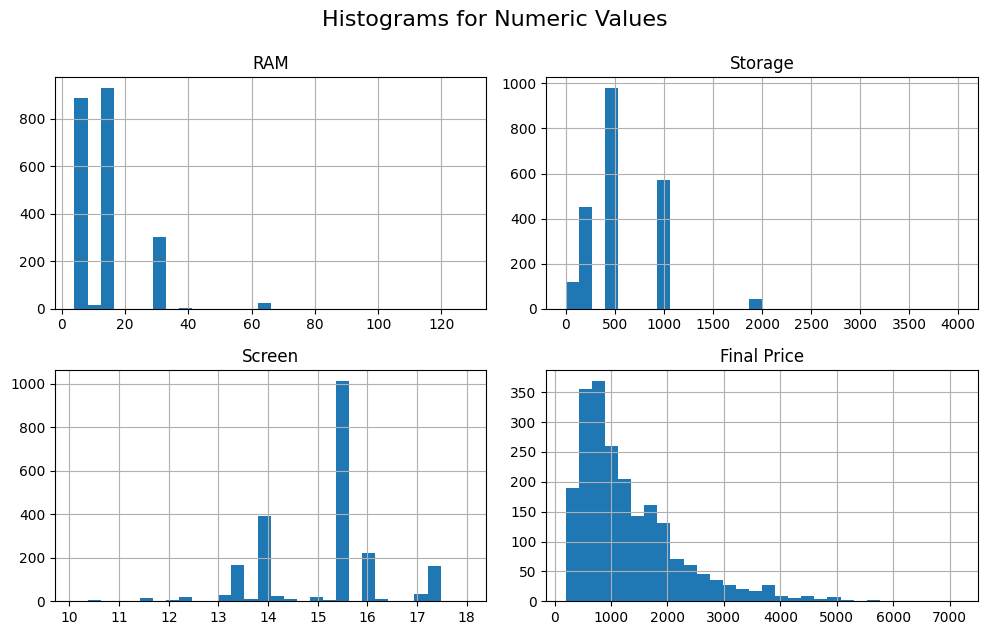

In [3]:
# Visual 1 Hisogram
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns].hist(figsize=(10, 6), bins=30)
plt.tight_layout()
plt.suptitle('Histograms for Numeric Values', y=1.05, fontsize=16)
plt.show()

#### Scatter Matrix

From the four histograms above, we compute a 4x4 Matrix which demonstrates which values will likely create a regressional trend-line for the model. This is important for understanding how each numeric input correlates with the final price.

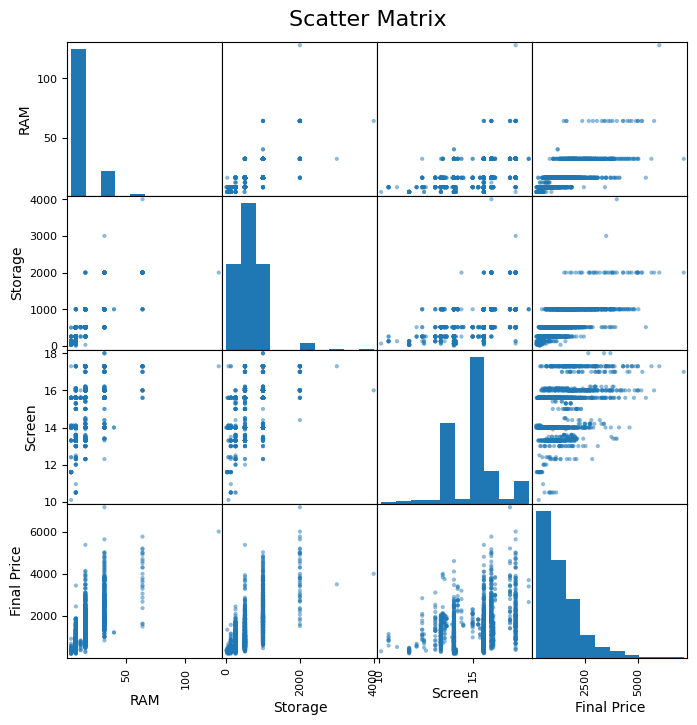

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, figsize=(8, 8), diagonal='hist', alpha=0.5)
plt.suptitle('Scatter Matrix', y=0.92, fontsize=16)
plt.show()

#### Bar Graph

Breakdown of New vs. Refurbished Laptops in the dataset. As intuition would lend, with the exception of certain high-end devices existing far outside of the standard deviation and therefore hold a value for longer, most refurbished laptops are sold in a budget range of 400-800, and we see disproportionately less refurbished devices as the price band increases and a larger proportion of 'New' devices.

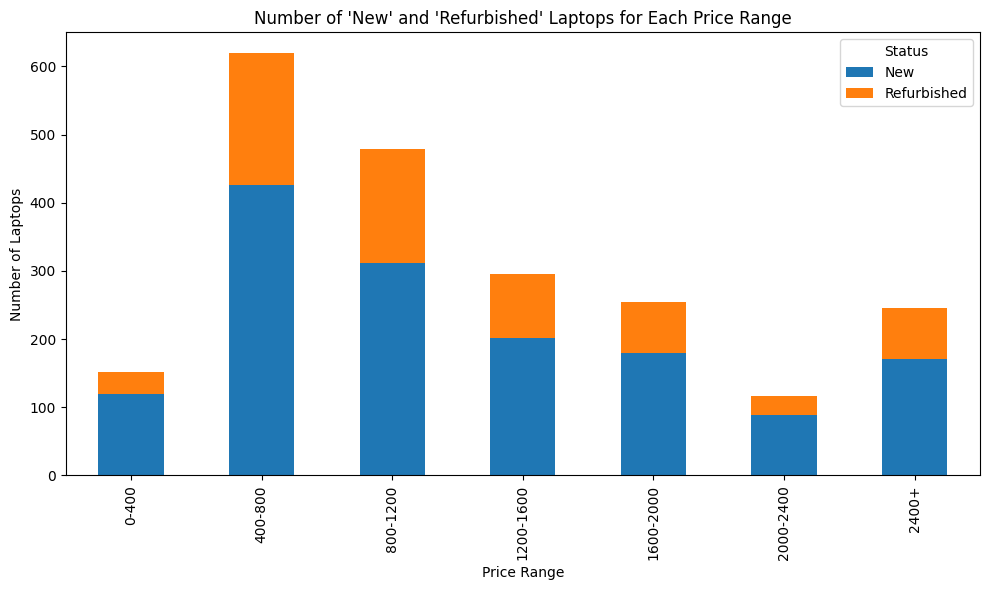

In [5]:
# Construct Stacked Bar-Graph
bins = [0, 400, 800, 1200, 1600, 2000, 2400, np.inf]
bin_labels = ["0-400", "400-800", "800-1200", "1200-1600", "1600-2000", "2000-2400", "2400+"]
df["Price Range"] = pd.cut(df["Final Price"], bins=bins, labels=bin_labels, right=False)
grouped = df.groupby(["Price Range", "Status"]).size().unstack().fillna(0)
grouped.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Number of 'New' and 'Refurbished' Laptops for Each Price Range")
plt.xlabel("Price Range")
plt.ylabel("Number of Laptops")
plt.legend(title="Status")
plt.tight_layout()
plt.show()

### 2. Crafting and Training MarketMean

The independent variables we want MarketMean to use are:
- __Status__: Is the Laptop sold new, or was it refurbished?
- __Brand__: How much does the name on the packaging impact that final price?
- __Model__: The subtitle to the brand, how much does the model's name impact the price?
- __CPU__: The central computing unit, as described by the Brand/Model of that component.
- __RAM__: The amount Random-Access Memory, cached for immediate use to dramatically increase the amount of simultaneous tasks the device can handle.
- __Storage__: The amount of drive storage that the device holds for long-term use.
- __Storage Type__: Indicates whether the device has a Standard Drive or Solid Slate, if a device has both, SSD is chosen and used as the measure.
- __GPU__: Whether the device has a dedicated Graphical Computing Unit for rendering graphics. Indicated by Brand/Model of that component.
- __Screen__ Size: The measure, in inches, of how long the diagonal length of the screen is from one corner to its opposite.
- __Touchscreen__: Whether or not the device has a touch-enabled screen.

The dependent variable is the actual 'Final Price' from the dataset.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

# Independent and Dependent Variables
X = df.drop(columns=["Laptop", "Final Price"])
y = df["Final Price"]

# Separate Numerical and Categorical Columns
categories = X.select_dtypes(include=["object"]).columns.tolist()
numbers = X.select_dtypes(exclude=["object"]).columns.tolist()

# Numerical and Categorical Transformers
numerical_transformer = SimpleImputer(strategy="mean")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Form a preprocessor on both sets.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numbers),
        ("cat", categorical_transformer, categories)
    ])
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

# Creates and Evaluates a Merged Pipeline:
# Used for training the model from scratch

# pipeline = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", LinearRegression())
# ])
# pipeline.fit(X_train, y_train)
# predictions = pipeline.predict(X_test)

,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Price Range
1776,Refurbished,Asus,F515,Intel Core i7,8,512,SSD,No GPU,15.6,No,400-800
381,New,HP,Chromebook,Intel Celeron,4,64,eMMC,No GPU,14.0,Yes,0-400
1242,New,Asus,ROG,AMD Ryzen 7,16,512,SSD,RTX 3050,15.6,No,800-1200
1805,Refurbished,Asus,ROG,Intel Core i7,16,1000,SSD,RTX 2070,15.6,No,1200-1600
1865,Refurbished,Gigabyte,Aorus,Intel Core i7,16,512,SSD,RTX 2070,15.6,No,800-1200


##### (2-A) Saving the Model

If you are training the model from scratch, you can save it using a joblib file. Just make sure it's not using the name of an existing file in the directory.

In [7]:
# joblib.dump(pipeline, 'marketmean_new.joblib')

### 3. Training Performance Results

Here we train the linear regression model, and use MAE, MSE, and R2 as metrics to evaluate how accurately our model predicted a laptop price.
- Mean Absolute Error: When the model messes up on a guess, the amount the guess (+/-) was off by is added to a sum as an absolute value. Lower is better.
- Mean Squared Error: Like MAE, this follows a similar pattern of measuring total errors but it squares the result, lower is still better.
- R-Squared Score: Measures the variance of dependent variable sfrom independent. The closer to 1 the better.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = joblib.load('marketmean.joblib')
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'{line_break*2}\nMean Absolute Error:  {mae:.3f}\n{line_break*2}',
    f'\nMean Squared Error:   {mse:.3f}\n{line_break*2}\nR-Squared Score:      {r2:.4f}\n{line_break*2}')


----------------------------------------
Mean Absolute Error:  226.350
---------------------------------------- 
Mean Squared Error:   110931.100
----------------------------------------
R-Squared Score:      0.8797
----------------------------------------


### 4. Interactive Widgets

Use the interactive UI elements below to see what predictions the Model will give you. Get creative!

In [9]:
import ipywidgets as widgets
from IPython.display import display, clear_output

status_widget = widgets.Dropdown(
    options=df['Status'].unique().tolist(),
    value=df['Status'].iloc[0],
    description='Status:',
    disabled=False,
)

brand_widget = widgets.Dropdown(
    options=sorted(df['Brand'].unique().tolist()),
    value=df['Brand'].iloc[0],
    description='Brand:',
    disabled=False,
)

model_widget = widgets.Dropdown(
    options=sorted(df['Model'].unique().tolist()),
    value=df['Model'].iloc[0],
    description='Model:',
    disabled=False,
)

cpu_widget = widgets.Dropdown(
    options=df['CPU'].unique().tolist(),
    value=df['CPU'].iloc[0],
    description='CPU:',
    disabled=False,
)

storage_type_widget = widgets.Dropdown(
    options=df['Storage type'].unique().tolist(),
    value=df['Storage type'].iloc[0],
    description='Storage Type:',
    disabled=False,
)

gpu_widget = widgets.Dropdown(
    options=sorted(df['GPU'].unique().tolist()),
    value=df['GPU'].iloc[0],
    description='GPU:',
    disabled=False,
)

ram_widget = widgets.IntSlider(
    value=df['RAM'].median(),
    min=df['RAM'].min(),
    max=df['RAM'].max(),
    step=1,
    description='RAM (GB):',
    continuous_update=False
)

storage_widget = widgets.IntSlider(
    value=df['Storage'].median(),
    min=df['Storage'].min(),
    max=df['Storage'].max(),
    step=1,
    description='Storage (GB):',
    continuous_update=False
)

screen_widget = widgets.FloatSlider(
    value=df['Screen'].median(),
    min=df['Screen'].min(),
    max=df['Screen'].max(),
    step=0.1,
    description='Screen (inches):',
    continuous_update=False
)

touch_widget = widgets.Dropdown(
    options=df['Touch'].unique().tolist(),
    value=df['Touch'].iloc[0],
    description='Touch:',
    disabled=False,
)

def predict_price(): # Status, Brand, Model, CPU, Storage_Type, RAM, Storage, Screen
    input_data = {
        'Status': [status_widget.value],
        'Brand': [brand_widget.value],
        'Model': [model_widget.value],
        'CPU': [cpu_widget.value],
        'Storage type': [storage_type_widget.value],
        'RAM': [ram_widget.value],
        'Storage': [storage_widget.value],
        'Screen': [screen_widget.value],
        'GPU': [gpu_widget.value],  # Placeholder value
        'Touch': ['Placeholder']  # Placeholder value
    }
    
    input_df = pd.DataFrame.from_dict(input_data)
    
    # Make prediction
    prediction = model.predict(input_df)
    
    # Return prediction
    return f"The Market Value for this Laptop Configuration is: € {prediction[0]:.2f}"


def predict_click(obj):
    with output:
        clear_output()
        current_prediction = predict_price()
        print(current_prediction)

predict_button = widgets.Button(description="Predict Price")
output = widgets.Output()

predict_button.on_click(predict_click)

display(status_widget, brand_widget, model_widget, cpu_widget, gpu_widget, storage_type_widget, 
        ram_widget, storage_widget, screen_widget, touch_widget, predict_button, output)


Dropdown(description='Status:', options=('New', 'Refurbished'), value='New')

Dropdown(description='Brand:', index=3, options=('Acer', 'Alurin', 'Apple', 'Asus', 'Deep Gaming', 'Dell', 'De…

Dropdown(description='Model:', index=42, options=('100e', '100w', '14S', '14w', '15S', '15U70N', '17', '250', …

Dropdown(description='CPU:', options=('Intel Core i5', 'Intel Celeron', 'Intel Core i3', 'Intel Core i7', 'AMD…

Dropdown(description='GPU:', index=11, options=('610 M', 'A 370M', 'A 730M', 'GTX 1050', 'GTX 1070', 'GTX 1650…

Dropdown(description='Storage Type:', options=('SSD', 'eMMC', 'Not Listed'), value='SSD')

IntSlider(value=16, continuous_update=False, description='RAM (GB):', max=128, min=4)

IntSlider(value=512, continuous_update=False, description='Storage (GB):', max=4000)

FloatSlider(value=15.6, continuous_update=False, description='Screen (inches):', max=18.0, min=10.1)

Dropdown(description='Touch:', options=('No', 'Yes'), value='No')

Button(description='Predict Price', style=ButtonStyle())

Output()